<h3 style="margin-bottom: 1em;"><img src="https://www.proteinmetrics.com/wp-content/uploads/2017/08/logo.svg" width="320" style="display: inline; margin: 0 2em 0 0;" /> Peak Deltas</h3>

In [1]:
import os
import re
import sqlite3
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.signal as sig
import scipy.stats
from pyteomics import mzml
from IPython.display import HTML, Markdown, display_html
from scipy.optimize import curve_fit

In [2]:
# global settings and variables
pd.set_option('display.float_format', lambda x: '%.4f' % x)
connections = {}

In [3]:
def display_side_by_side(*args):
    html_str=''
    for df in args:
        html_str+=df.to_html()
    display_html(html_str.replace('table','table style="display:inline"'),raw=True)



def fetch_peaks_from_byspec2(byspec2_path, offset=0, limit=1000):
    global connections
    if byspec2_path not in connections:
        connections[byspec2_path] = sqlite3.connect(byspec2_path)
        
    conn   = connections[byspec2_path]
    query  = "SELECT s.Id, s.RetentionTime, s.ScanNumber, s.NativeId, p.PeaksMz, p.PeaksIntensity " + \
             "FROM Spectra AS s JOIN Peaks AS p ON (s.PeaksId = p.Id)" + \
             "WHERE (s.MSLevel = 1) AND (p.PeaksCount > 0) " + \
             "LIMIT {},{}".format(offset, limit)
    return conn.execute(query).fetchall()

In [4]:
def get_scans(byspec2_path, offset, limit):
    result = fetch_peaks_from_byspec2(byspec2_path, offset, limit)
    return [
        {
            'id':       row[0],
            'rt':       row[1],
            'number':   row[2],
            'nativeId': row[3],
            'mz':       np.frombuffer(row[4], dtype=np.float64),
            'intens':   np.frombuffer(row[5], dtype=np.float32)
        }
        for row in result
    ]

--- 
### Peak-Delta Metric

In [7]:
full_centroid_mode_byspec2_filename = './prg.centroid_const_01_fullgauss.byspec2'
wopico_centroid_mode_byspec2_filename = './prg.centroid_const_01_fullgauss_wopico.byspec2'

#if 'BYSPEC2_FILE' in os.environ:
#    display('WARNING: using BYSPEC2_FILE set through env var:', os.environ['BYSPEC2_FILE'])
#    centroid_mode_byspec2_filename = os.environ['BYSPEC2_FILE']

In [10]:
offset = int(os.environ.get('BYSPEC2_OFFSET', '2000'))
limit  = int(os.environ.get('BYSPEC2_LIMIT',  '1000'))
full_scans  = get_scans(full_centroid_mode_byspec2_filename, offset, limit)
wop_scans  = get_scans(wopico_centroid_mode_byspec2_filename, offset, limit)
display('Sample full gaussian scan:', full_scans[len(full_scans) // 2]['id'])
display('Sample wo picomz scan:', wop_scans[len(wop_scans) // 2]['id'])

'Sample full gaussian scan:'

14731

'Sample wo picomz scan:'

14731

In [11]:
# visually check the dataset by plotting the profile-mode spectra
#fig, ax = plt.subplots(1, 1, figsize=(16,5))
#fscan = full_scans[len(full_scans) // 2]
#ax.stem(fscan['mz'], fscan['intens'], use_line_collection=True, linefmt='b-', markerfmt=' ');
# ax.set_xlim(915, 918)
#display(Markdown('#### Check spectra - Full Gaussian Scan #{}'.format(fscan['id'])))

In [12]:
def build_diff_dataframe(scans, NDIFFS=4, MAXDIFF=3.0):
    def _mzdiff(mz, i):
        diff = (mz[i:] - mz[:-i])[:mz.size - NDIFFS]
        diff[diff > MAXDIFF] = np.NaN
        return diff 

    def _diff_rowdata(scan):
        return np.stack(
            [np.full((scan['mz'].size - NDIFFS,), scan['id'], dtype=np.int32), scan['mz'][:-NDIFFS]] +
            [_mzdiff(scan['mz'], i) for i in range(1, NDIFFS + 1)],
            axis=1
        )

    data = np.concatenate([
        _diff_rowdata(scan)
        for scan in scans
        if scan['mz'].size >= NDIFFS
    ], axis=0)
    columns = np.array(['scan id', 'mz'] + ['diff{:02d}'.format(i) for i in range(1, NDIFFS + 1)])

    df = pd.DataFrame(columns=columns, data=data)
    df['scan id'] = df['scan id'].astype('int32')
    return df

fdf = build_diff_dataframe(full_scans)
wdf = build_diff_dataframe(wop_scans)
display('Full Gaussian / With out PIcoMZ Gaussian centroiding')

display_side_by_side(fdf.describe(), wdf.describe())
# display(fdf.describe())
# display(mdf.describe())

#display_side_by_side(fdf.sample(4), mdf.sample(4))
#display(fdf.sample(4))
#display(mdf.sample(4))


'Full Gaussian / With out PIcoMZ Gaussian centroiding'

scan id 
 mz 
 diff01 
 diff02 
 diff03 
 diff04 
 
 
 
 
 count 
 995895.0000 
 995895.0000 
 966222.0000 
 925102.0000 
 871066.0000 
 803254.0000 
 
 
 mean 
 14596.8649 
 625.6704 
 0.4347 
 0.8086 
 1.1304 
 1.4021 
 
 
 std 
 2722.3182 
 145.7562 
 0.4278 
 0.5583 
 0.6222 
 0.6425 
 
 
 min 
 9731.0000 
 400.0173 
 0.0001 
 0.0172 
 0.0282 
 0.0413 
 
 
 25% 
 12182.0000 
 514.9420 
 0.1860 
 0.4282 
 0.6668 
 0.9502 
 
 
 50% 
 14720.0000 
 605.6530 
 0.3310 
 0.6618 
 0.9988 
 1.3108 
 
 
 75% 
 17234.0000 
 704.3530 
 0.5021 
 1.0043 
 1.4950 
 1.8922 
 
 
 max 
 18844.0000 
 1245.2448 
 3.0000 
 3.0000 
 3.0000 
 3.0000 
 
 
 
 
 
 
 scan id 
 mz 
 diff01 
 diff02 
 diff03 
 diff04 
 
 
 
 
 count 
 996000.0000 
 996000.0000 
 966319.0000 
 925188.0000 
 871181.0000 
 803353.0000 
 
 
 mean 
 14597.0470 
 625.6801 
 0.4347 
 0.8085 
 1.1303 
 1.4019 
 
 
 std 
 2722.3308 
 145.7549 
 0.4278 
 0.5582 
 0.6222 
 0.6425 
 
 
 min 
 9731.0000 
 400.0173 
 0.0085 
 0.0172 
 0.0282 
 0.0413 
 
 
 25% 
 12191.0000 
 514.9453 
 0.1859 
 0.4278 
 0.6664 
 0.9498 
 
 
 50% 
 14725.5000 
 605.6685 
 0.3308 
 0.6616 
 0.9985 
 1.3108 
 
 
 75% 
 17235.2500 
 704.3558 
 0.5020 
 1.0040 
 1.4948 
 1.8918 
 
 
 max 
 18844.0000 
 1245.2448 
 3.0000 
 3.0000 
 3.0000 
 3.0000

In [13]:
EXPECTED_MZ_DIFFS = np.array([(1 / x) for x in range(1, 13)])
def plot_mzdiff_hist(series, nbins=25, logscale=False, ax=None, title=None):
    ax   = series.hist(bins=nbins, ax=ax, figsize=(None if ax else (16, 4)))
    ymax = ax.get_ylim()[1]
    ax.stem(EXPECTED_MZ_DIFFS, np.full(EXPECTED_MZ_DIFFS.size, ymax),
            use_line_collection=True, linefmt='b-', markerfmt=' ');
    ax.set_xlim(0, 2.1)
    ax.set_title(title)
    if logscale:
        plt.yscale('log', nonposy='clip');

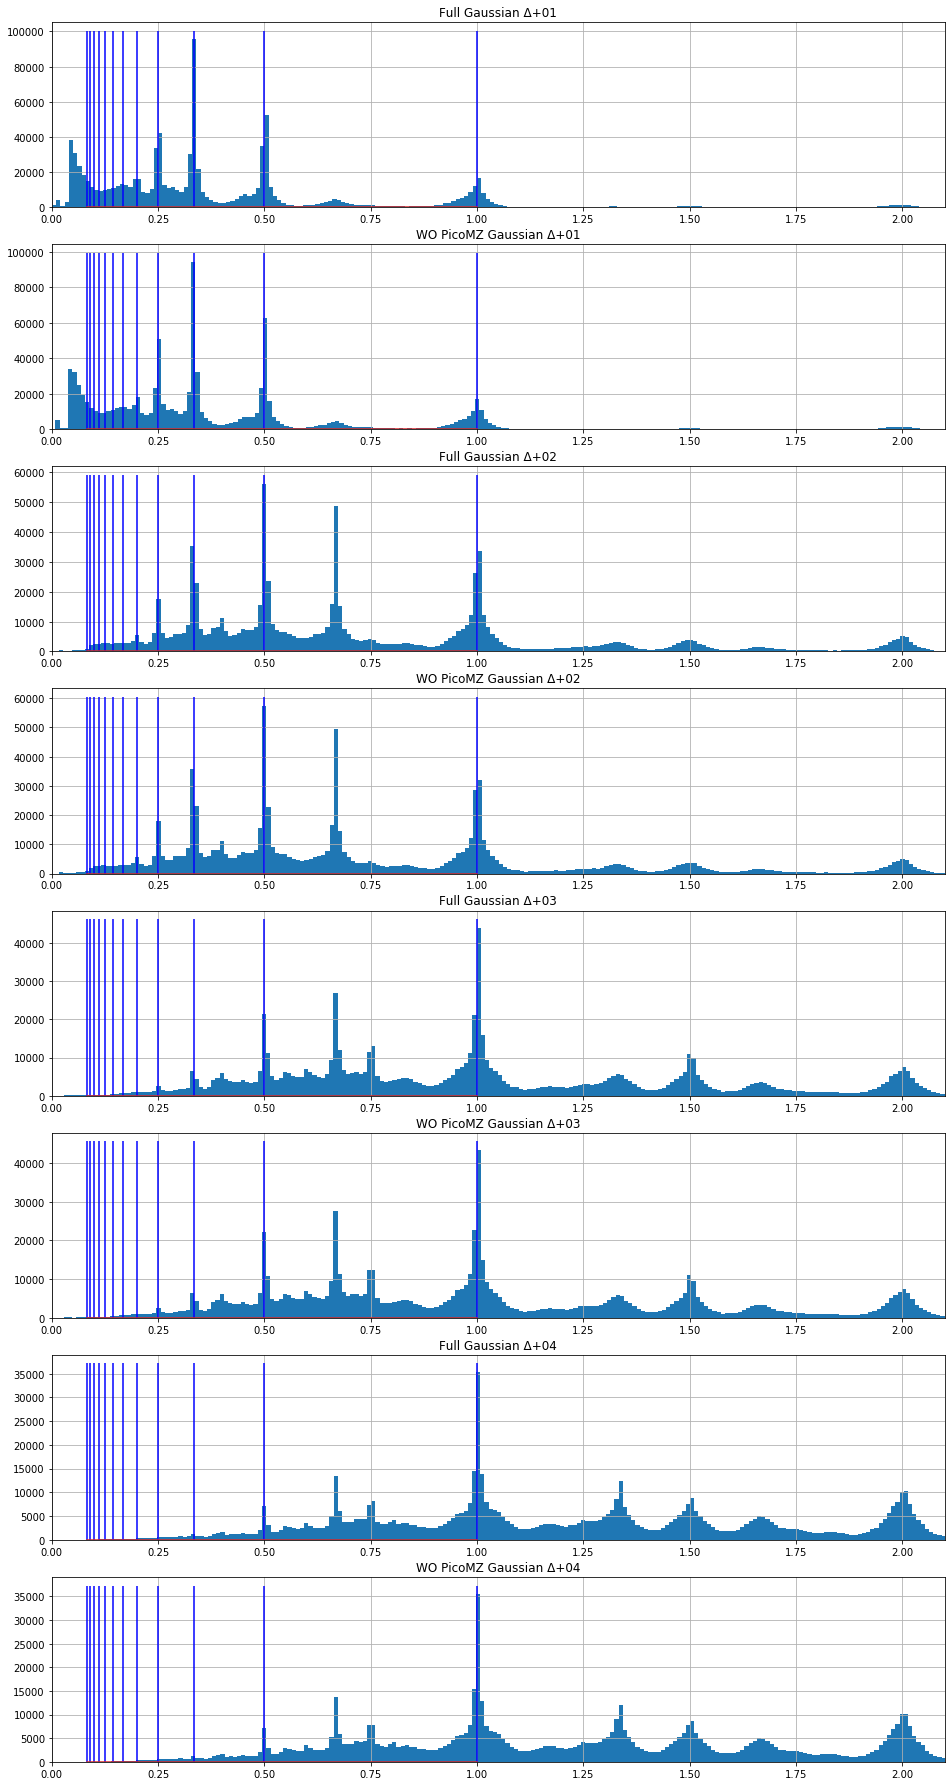

In [14]:
fdiff_cols = [col for col in fdf.columns if col.startswith('diff')]
wdiff_cols = [col for col in wdf.columns if col.startswith('diff')]

fig, axes = plt.subplots(len(fdiff_cols) + len(wdiff_cols), 1, figsize=(16, 4 * (len(fdiff_cols) + len(wdiff_cols)))) 
axes = list(axes)

for fcol, wcol in zip(fdiff_cols, wdiff_cols):
    plot_mzdiff_hist(fdf[fcol], nbins=300, logscale=False, ax=axes.pop(0),
                     title='Full Gaussian Δ+{}'.format(fcol[-2:]))
    plot_mzdiff_hist(wdf[wcol], nbins=300, logscale=False, ax=axes.pop(0),
                     title='WO PicoMZ Gaussian Δ+{}'.format(wcol[-2:]))                                                                            
                                                                                 

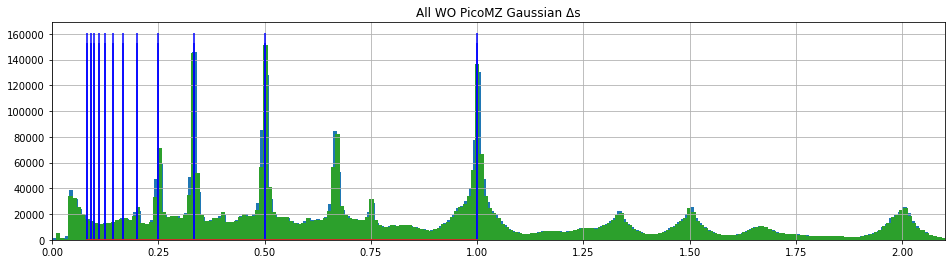

In [15]:
alldiff_fdf = pd.DataFrame(
    data=np.concatenate([fdf[col] for col in fdf.columns if col.startswith('diff')]),
    columns=['diff']
)
plot_mzdiff_hist(alldiff_fdf['diff'], nbins=300, title='All Full Gaussian Δs')

alldiff_wdf = pd.DataFrame(
    data=np.concatenate([wdf[col] for col in wdf.columns if col.startswith('diff')]),
    columns=['diff']
)
plot_mzdiff_hist(alldiff_wdf['diff'], nbins=300, title='All WO PicoMZ Gaussian Δs')

In [20]:
def display_mzdiff_stats(fseries, wseries, ftitle, mtitle, in_range_percentage=10.0):
    def _points_in_range(series, ref_value):
        abs_range = (ref_value * in_range_percentage / 100.0)
        return series[abs(series - ref_value) < abs_range]
    
    def _stats(series, expected_diff):
        nearby_points = _points_in_range(series, expected_diff)
        return [
            expected_diff, nearby_points.count(), nearby_points.std(),
            scipy.stats.variation(nearby_points.values, nan_policy='omit')
        ]
    
    fdata = [ _stats(fseries, expected_diff) for expected_diff in EXPECTED_MZ_DIFFS ]
    wdata = [ _stats(wseries, expected_diff) for expected_diff in EXPECTED_MZ_DIFFS ]
    fstatsdf = pd.DataFrame(columns=['expected m/z diff', 'count', 'stddev', 'variation'], data=fdata)
    wstatsdf = pd.DataFrame(columns=['expected m/z diff', 'count', 'stddev', 'variation'], data=wdata)
    
    display(HTML('<h4>{}   ---     {}</h4>'.format(ftitle, wtitle)))
    display_side_by_side(fstatsdf, wstatsdf)
    
    fexpected = 100.0 * fstatsdf['count'].sum() / fseries.size
    wexpected = 100.0 * wstatsdf['count'].sum() / wseries.size    
    display(HTML('<span># points within {}% of expected diffs: </span>: <b>{} - {}  ({:.2f}%) - ({:.2f}%)</b>'.format(
        in_range_percentage, fstatsdf['count'].sum(), wstatsdf['count'].sum(), fexpected, wexpected)))
    

In [21]:
ftitle='Full Gaussian Nearest neighbor (mz[n+1] - mz[n])'
wtitle='WO PicoMZ Nearest neighbor (mz[n+1] - mz[n])'
display_mzdiff_stats(fdf['diff01'], wdf['diff01'], ftitle, wtitle)

ftitle='Full Gaussian Nearest neighbor (mz[n+2] - mz[n])'
wtitle='WO PicoMZ Nearest neighbor (mz[n+2] - mz[n])'
display_mzdiff_stats(fdf['diff02'], wdf['diff02'], ftitle, wtitle)

ftitle='Full Gaussian All neighbors ((n+1), (n+2), ... (n+4)'
wtitle='WO PicoMZ All neighbors ((n+1), (n+2), ... (n+4)'

display_mzdiff_stats(alldiff_fdf['diff'], alldiff_wdf['diff'], ftitle, wtitle)


expected m/z diff 
 count 
 stddev 
 variation 
 
 
 
 
 0 
 1.0000 
 86172 
 0.0336 
 0.0340 
 
 
 1 
 0.5000 
 144980 
 0.0182 
 0.0366 
 
 
 2 
 0.3333 
 181008 
 0.0115 
 0.0344 
 
 
 3 
 0.2500 
 108472 
 0.0103 
 0.0411 
 
 
 4 
 0.2000 
 52176 
 0.0102 
 0.0515 
 
 
 5 
 0.1667 
 41480 
 0.0094 
 0.0565 
 
 
 6 
 0.1429 
 31217 
 0.0083 
 0.0577 
 
 
 7 
 0.1250 
 24179 
 0.0072 
 0.0577 
 
 
 8 
 0.1111 
 20948 
 0.0064 
 0.0582 
 
 
 9 
 0.1000 
 21602 
 0.0057 
 0.0578 
 
 
 10 
 0.0909 
 23613 
 0.0053 
 0.0583 
 
 
 11 
 0.0833 
 25535 
 0.0047 
 0.0572 
 
 
 
 
 
 
 expected m/z diff 
 count 
 stddev 
 variation 
 
 
 
 
 0 
 1.0000 
 86162 
 0.0336 
 0.0340 
 
 
 1 
 0.5000 
 144924 
 0.0182 
 0.0365 
 
 
 2 
 0.3333 
 180721 
 0.0114 
 0.0343 
 
 
 3 
 0.2500 
 108361 
 0.0103 
 0.0409 
 
 
 4 
 0.2000 
 52133 
 0.0102 
 0.0513 
 
 
 5 
 0.1667 
 41542 
 0.0094 
 0.0565 
 
 
 6 
 0.1429 
 31202 
 0.0083 
 0.0577 
 
 
 7 
 0.1250 
 24171 
 0.0072 
 0.0577 
 
 
 8 
 0.1111 
 20976 
 0.0064 
 0.0580 
 
 
 9 
 0.1000 
 21723 
 0.0057 
 0.0578 
 
 
 10 
 0.0909 
 23683 
 0.0053 
 0.0585 
 
 
 11 
 0.0833 
 25657 
 0.0048 
 0.0574

expected m/z diff 
 count 
 stddev 
 variation 
 
 
 
 
 0 
 1.0000 
 153165 
 0.0352 
 0.0353 
 
 
 1 
 0.5000 
 148016 
 0.0204 
 0.0408 
 
 
 2 
 0.3333 
 90176 
 0.0132 
 0.0397 
 
 
 3 
 0.2500 
 37461 
 0.0107 
 0.0425 
 
 
 4 
 0.2000 
 15184 
 0.0102 
 0.0509 
 
 
 5 
 0.1667 
 9645 
 0.0096 
 0.0578 
 
 
 6 
 0.1429 
 7641 
 0.0084 
 0.0585 
 
 
 7 
 0.1250 
 6680 
 0.0071 
 0.0571 
 
 
 8 
 0.1111 
 5686 
 0.0063 
 0.0568 
 
 
 9 
 0.1000 
 4731 
 0.0056 
 0.0559 
 
 
 10 
 0.0909 
 3430 
 0.0049 
 0.0536 
 
 
 11 
 0.0833 
 1803 
 0.0041 
 0.0484 
 
 
 
 
 
 
 expected m/z diff 
 count 
 stddev 
 variation 
 
 
 
 
 0 
 1.0000 
 153147 
 0.0352 
 0.0354 
 
 
 1 
 0.5000 
 148030 
 0.0204 
 0.0408 
 
 
 2 
 0.3333 
 90138 
 0.0132 
 0.0395 
 
 
 3 
 0.2500 
 37451 
 0.0106 
 0.0424 
 
 
 4 
 0.2000 
 15175 
 0.0101 
 0.0508 
 
 
 5 
 0.1667 
 9642 
 0.0097 
 0.0580 
 
 
 6 
 0.1429 
 7658 
 0.0084 
 0.0585 
 
 
 7 
 0.1250 
 6747 
 0.0072 
 0.0574 
 
 
 8 
 0.1111 
 5679 
 0.0063 
 0.0565 
 
 
 9 
 0.1000 
 4731 
 0.0056 
 0.0560 
 
 
 10 
 0.0909 
 3432 
 0.0049 
 0.0536 
 
 
 11 
 0.0833 
 1775 
 0.0041 
 0.0480

expected m/z diff 
 count 
 stddev 
 variation 
 
 
 
 
 0 
 1.0000 
 562319 
 0.0377 
 0.0378 
 
 
 1 
 0.5000 
 386156 
 0.0205 
 0.0411 
 
 
 2 
 0.3333 
 296450 
 0.0125 
 0.0374 
 
 
 3 
 0.2500 
 155838 
 0.0106 
 0.0422 
 
 
 4 
 0.2000 
 71926 
 0.0103 
 0.0517 
 
 
 5 
 0.1667 
 53773 
 0.0095 
 0.0568 
 
 
 6 
 0.1429 
 40260 
 0.0083 
 0.0578 
 
 
 7 
 0.1250 
 31540 
 0.0072 
 0.0575 
 
 
 8 
 0.1111 
 27086 
 0.0064 
 0.0579 
 
 
 9 
 0.1000 
 26662 
 0.0057 
 0.0575 
 
 
 10 
 0.0909 
 27285 
 0.0053 
 0.0582 
 
 
 11 
 0.0833 
 27515 
 0.0048 
 0.0573 
 
 
 
 
 
 
 expected m/z diff 
 count 
 stddev 
 variation 
 
 
 
 
 0 
 1.0000 
 562233 
 0.0378 
 0.0378 
 
 
 1 
 0.5000 
 386148 
 0.0205 
 0.0411 
 
 
 2 
 0.3333 
 296136 
 0.0124 
 0.0372 
 
 
 3 
 0.2500 
 155704 
 0.0105 
 0.0420 
 
 
 4 
 0.2000 
 71869 
 0.0103 
 0.0515 
 
 
 5 
 0.1667 
 53843 
 0.0095 
 0.0568 
 
 
 6 
 0.1429 
 40256 
 0.0083 
 0.0578 
 
 
 7 
 0.1250 
 31598 
 0.0072 
 0.0576 
 
 
 8 
 0.1111 
 27107 
 0.0064 
 0.0577 
 
 
 9 
 0.1000 
 26783 
 0.0057 
 0.0575 
 
 
 10 
 0.0909 
 27357 
 0.0053 
 0.0584 
 
 
 11 
 0.0833 
 27608 
 0.0048 
 0.0575